In [ ]:
!pip install gym[atari,accept-rom-license] atari-py
!pip install moviepy
# in case you get a error saying: "cannot import name 'NotRequired' from 'typing_extensions'". Do these:
# !pip uninstall tensorflow-gpu
#!pip install --upgrade typing-extensions

In [1]:
%matplotlib inline

In [9]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Pretrained model utils
from play import *

# Note: Depending on what we need in the assignment, we can use various gym wrappers, Monitor wrapper, video recording wrapper, etc
from gym.wrappers import AtariPreprocessing, FrameStack

# Using Atari preprocessing requires us to use NoFramesskip environment instead of the usual Breakout-v4
env_ = gym.make("BreakoutNoFrameskip-v4",render_mode='rgb_array')
env = AtariPreprocessing(env_, scale_obs=False)  # auto skips 4 frames, converts grayscale


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
BATCH_SIZE = 128 # Transcations to be sampled from replay buffer
GAMMA = 0.99 # discount factor
TAU = 0.005#Updation rate
LR = 1e-4#learning rate
EPS_START = 0.9#beginning value of epsilon
EPS_END = 0.05 # epsilon value after decay
EPS_DECAY = 1000# Rate of epsilon decay in epsilon greedy approach

In [10]:
n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

def getEpsilon():
    return EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

def select_action(state):
    global steps_done
    steps_done += 1
    if random.random() > getEpsilon():
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


def plot_durations(show_result=False, saveFig=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    means = torch.zeros(99)#torch.tensor([durations_t[:i+1].mean() for i in range(min(len(durations_t), 100))])
    if len(durations_t)>=100:  
        means_later = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((means, means_later))
    plt.plot(means.numpy())
    if saveFig:
        plt.savefig(f"{EXP_NAME}/durations.jpg")
    
#     plt.pause(0.001)  # pause a bit so that plots are updated
    plt.close()
    if is_ipython:
        return
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
def plot_rewards(show_result=False, clipAt=10000, saveFig=False):
    plt.figure(1)
    durations_t = torch.tensor([x if x<clipAt else clipAt for x in rewards_episodes], dtype=torch.float)[:450]
    if show_result:
        plt.title('SpaceInvaders Within-Game RL')
    else:
        plt.clf()
        plt.title('SpaceInvaders Within-Game RL')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    means = torch.zeros(99)#torch.tensor([durations_t[:i+1].mean() for i in range(min(len(durations_t), 100))])
    if len(durations_t)>=100:  
        means_later = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((means, means_later))
    plt.plot(means.numpy())
    if saveFig:
        plt.savefig(f"{EXP_NAME}/rewards.jpg")
        
    plt.close()

#     plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            return
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
            
def plot_losses(show_result=False, saveFig=False):
    plt.figure(1)
    durations_t = torch.tensor([x for x in episode_losses], dtype=torch.float)[:450]
    if show_result:
        plt.title('SpaceInvaders Within-Game RL')
    else:
        plt.clf()
        plt.title('SpaceInvaders Within-Game RL')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    means = torch.zeros(99)#torch.tensor([durations_t[:i+1].mean() for i in range(min(len(durations_t), 100))])
    if len(durations_t)>=100:  
        means_later = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((means, means_later))
    plt.plot(means.numpy())
    if saveFig:
        plt.savefig(f"{EXP_NAME}/losses.jpg")
    plt.close()
#     plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            return
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
Interaction = namedtuple('Interaction',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append(Interaction(state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
def optimize_model(updateParams = True):
    if len(memory) < BATCH_SIZE:
        return
    Interactions = memory.sample(BATCH_SIZE)

    batch = Interaction(*zip(*Interactions))

    # Mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)#.unsqueeze(1)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # V(s_{t+1})
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    
    # expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()

    if updateParams:
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimizer.step()
    
    return loss.item()

In [11]:
# Introducing Frame stack to get vel, acc, etc
env = FrameStack(env, num_stack=4)

record_every = 100

#record video for every even episodes
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x % record_every == 0)

In [24]:
def _load_checkpoint(fpath, device="cpu"):
    fpath = Path(fpath)
    with fpath.open("rb") as file:
        with GzipFile(fileobj=file) as inflated:
            return torch.load(inflated, map_location=device)

path = "models/DQN_modern/Breakout/2/model_50000000.gz"

pretrained_model = AtariNet(env.action_space.n, distributional="C51_" in path)
ckpt = _load_checkpoint(path)
pretrained_model.load_state_dict(ckpt["estimator_state"])

<All keys matched successfully>

In [25]:
class DQN_Atari(nn.Module):
    """ Estimator used by DQN-style algorithms for ATARI games.
        Works with DQN, M-DQN and C51.
    """
    def __init__(self, action_no, distributional=False):
        super().__init__()

        self.action_no = out_size = action_no
        self.distributional = distributional

        # configure the support if distributional
        if distributional:
            support = torch.linspace(-10, 10, 51)
            self.__support = nn.Parameter(support, requires_grad=False)
            out_size = action_no * len(self.__support)

        # get the feature extractor and fully connected layers
#         self.__features = nn.Sequential(
#             nn.Conv2d(4, 32, kernel_size=8, stride=4),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1),
#             nn.ReLU(inplace=True),
#         )
#         def _load_checkpoint(fpath, device="cpu"):
#             fpath = Path(fpath)
#             with fpath.open("rb") as file:
#                 with GzipFile(fileobj=file) as inflated:
#                     return torch.load(inflated, map_location=device)
        
#         path = "models/DQN_modern/Breakout/2/model_50000000.gz"
        
#         pretrained_model = AtariNet(env.action_space.n, distributional="C51_" in path)
#         ckpt = _load_checkpoint(path)
#         pretrained_model.load_state_dict(ckpt["estimator_state"])
    
        self.__features = pretrained_model._AtariNet__features
        for param in self.__features.parameters():
            param.requires_grad = False

        self.__head = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512), nn.ReLU(inplace=True), nn.Linear(512, out_size),
        )

    def forward(self, x):
        x = x.clamp(0, 255).to(torch.uint8)
        assert x.dtype == torch.uint8, "The model expects states of type ByteTensor"
        x = x.float().div(255)

        x = self.__features(x)
        qs = self.__head(x.view(x.size(0), -1))

        if self.distributional:
            logits = qs.view(qs.shape[0], self.action_no, len(self.__support))
            qs_probs = torch.softmax(logits, dim=2)
            return torch.mul(qs_probs, self.__support.expand_as(qs_probs)).sum(2)
        return qs

In [26]:
policy_net = DQN_Atari(n_actions).to(device)
target_net = DQN_Atari(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

rewards_episodes = []
episode_durations = []

i_episode = -1

# env = AtariPreprocessing(env_, scale_obs=False)

In [ ]:
import sys
if torch.cuda.is_available():
    total_episodes = 5000# Default was 600
else:
    total_episodes = 50
    
EXP_NAME = "Breakout"
import os
if not os.path.exists(EXP_NAME):
    os.mkdir(EXP_NAME)

while i_episode < total_episodes:
    i_episode += 1
    # Initialize the environment and get it's state
    state, info = env.reset()
    print(f"In {i_episode}th episode--------------> ")
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        #print(observation.shape)
        
        episode_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the Interaction in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_losses.append(optimize_model(updateParams=False))
            rewards_episodes.append(episode_reward)
            print(f"Episode reward: {episode_reward}, Episode Loss: {episode_losses[-1]}, Episode Duration: {t+1}")
            
            if i_episode%100==0:
                torch.save(target_net.state_dict(), "target_net.pth")
                torch.save(policy_net.state_dict(), "policy_net.pth")
            if i_episode%10==0:
                # IMPORTANT: Change clipat to be the max value of reward you might wanna see in your plots
                plot_rewards(show_result=False, clipAt=10000, saveFig=True)
                plot_losses(show_result=False, saveFig=True)
                plot_durations(show_result=False, saveFig=True)
            break

In [ ]:
# env_wrapped.reset()
# obs, _, _, _, _ = env_wrapped.step(action=0)
# obs.shape
# (84, 84)
# env_wrapped.action_space

# Debug statements for replay memory
# a = memory.memory[0].state==memory.memory[0].next_state
# print(memory.memory[0].state[a==False])
# print(memory.memory[0].next_state[a==False])

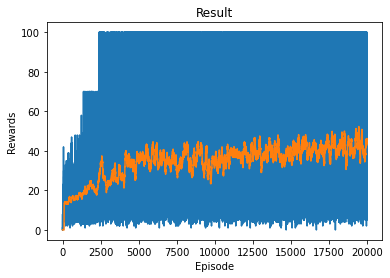

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [131]:
def plot_rewards(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor([x if x<100 else 100 for x in rewards_episodes], dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        global means
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
            
plot_rewards(show_result=True)

In [136]:
" & ".join([str(round(x, 2)) for x in means[[100, 500, 1000, 2000, 5000, 10000, 15000, 19977]].tolist()])

'12.11 & 14.98 & 15.79 & 22.26 & 34.92 & 32.81 & 39.44 & 46.16'

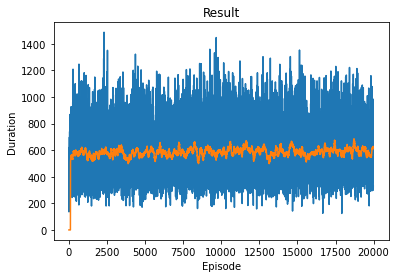

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [137]:
plot_durations(show_result=True)